## Business Case:- Rice Grain Image Dataset
This dataset consists of images of rice grains from different varieties, including Karacadag, Ipsala, and Arborio. It is intended for use in image processing and machine learning tasks, such as classification or morphological analysis, where the objective might be to distinguish between different rice varieties based on visual features.

## Importing the libraries

In [1]:
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE = 250
BATCH_SIZE = 10
chennels = 3
epochs = 10

## Importing data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('Rice_Image_Dataset',shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 15000 files belonging to 5 classes.


## Domain analysis and Data Information

#### Classes: 

● Arborio Rice     ● Basmati Rice     ●  Ipsala Rice      ● Jasmine Rice     ● Karacadag Rice 

### 1. Arborio Rice
- **Domain**: Culinary, particularly Italian cuisine
- **Characteristics**: Arborio rice is a short-grain variety known for its high starch content, which gives it a creamy texture when cooked. It’s primarily used for making risotto.
- **Geographical Significance**: Named after the Arborio region in Italy, though it is now grown in various places worldwide.
- **Uses**: Risotto, rice pudding; not typically used in dishes where separate grains are desired.
- **Texture**: Creamy, slightly chewy.

### 2. Basmati Rice
- **Domain**: Culinary, particularly South Asian cuisine
- **Characteristics**: Basmati is a long-grain rice known for its fragrant aroma and fluffy texture. It has a distinct nutty flavor and remains separate when cooked.
- **Geographical Significance**: Originates from the Indian subcontinent, especially India and Pakistan.
- **Uses**: Popular in biryanis, pilafs, and as a side dish with various curries.
- **Texture**: Light, fluffy, with distinct grains.

### 3. Ipsala Rice
- **Domain**: Culinary, particularly Mediterranean cuisine
- **Characteristics**: Ipsala is a type of Turkish rice known for its medium grain and slightly sticky texture. It’s often compared to other medium-grain varieties in terms of its cooking properties.
- **Geographical Significance**: Named after the town of Ipsala in Turkey.
- **Uses**: Used in a variety of dishes, including pilafs and as a side dish.
- **Texture**: Slightly sticky, but not as much as short-grain varieties.

### 4. Jasmine Rice
- **Domain**: Culinary, particularly Southeast Asian cuisine
- **Characteristics**: Jasmine rice is a long-grain rice known for its floral aroma and slightly sticky texture. It is grown primarily in Thailand.
- **Geographical Significance**: Originates from Thailand and is a staple in Thai cuisine.
- **Uses**: Commonly used in Thai dishes such as curries, stir-fries, and as a base for many Southeast Asian recipes.
- **Texture**: Soft, slightly sticky, with a fragrant aroma.

### 5. Karacadag Rice
- **Domain**: Culinary, Turkish cuisine
- **Characteristics**: Karacadag is a type of Turkish rice known for its medium-grain size and non-sticky texture. It’s considered to be of high quality in Turkish cooking.
- **Geographical Significance**: Named after the Karacadag region in Turkey.
- **Uses**: Suitable for pilafs, rice dishes, and as an accompaniment to various Turkish recipes.
- **Texture**: Non-sticky, fluffy when cooked.

### Summary:
- **Arborio**: Short-grain, creamy, Italian cuisine.
- **Basmati**: Long-grain, fragrant, South Asian cuisine.
- **Ipsala**: Medium-grain, slightly sticky, Mediterranean cuisine.
- **Jasmine**: Long-grain, aromatic, Southeast Asian cuisine.
- **Karacadag**: Medium-grain, non-sticky, Turkish cuisine.

Each rice variety has unique properties that make it suitable for specific culinary applications and regional dishes.

In [9]:
class_names = dataset.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [10]:
len(dataset)

1500

In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(10, 250, 250, 3)
[3 4 4 2 4 0 1 1 1 1]


## Observations
Each element in the dataset is a tuple. First element is a batch of 10 elements of images. Second element is a batch of 10 elements of class labels

## Data Visualiztion 

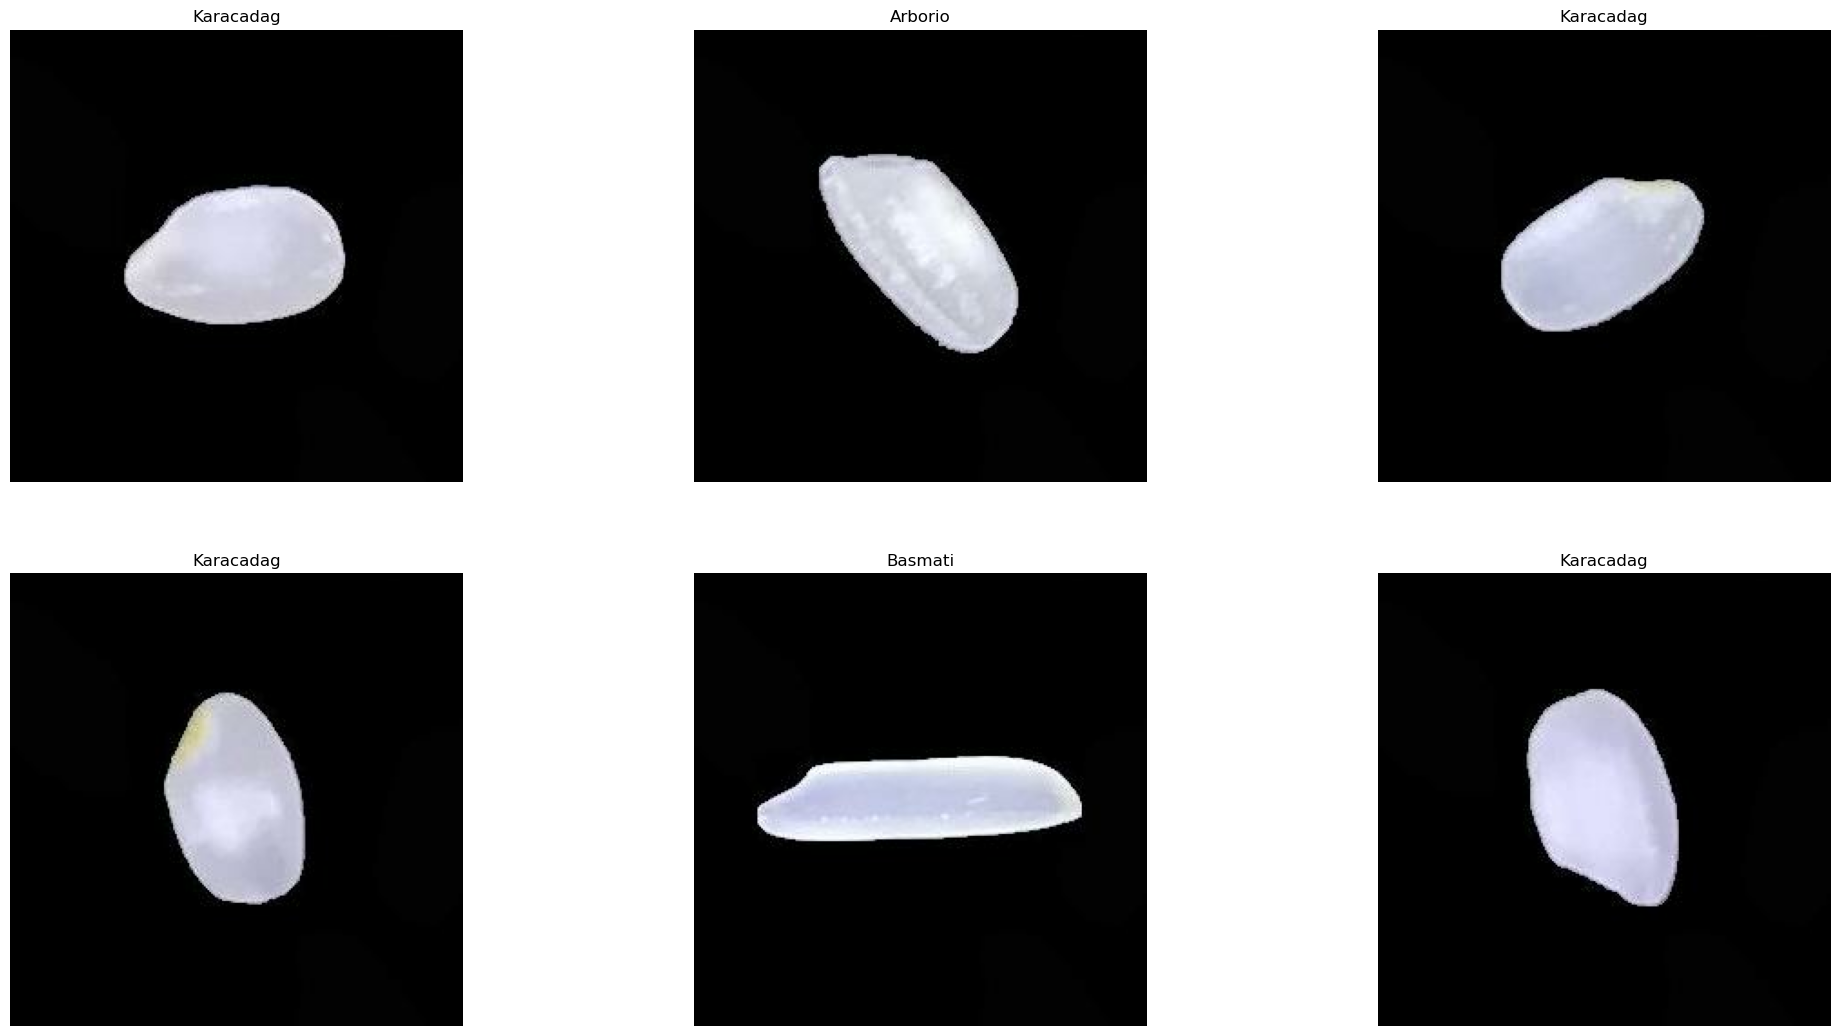

In [12]:
plt.figure(figsize=(25,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    

## Creating function to split the data for training, testing and validation.
Dividing dataset into 3 parts. Namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [18]:
#TensorFlow dataset specifying the proportion of data to allocate to training, validation, and test sets, respectively and shuffle the dataset in buffer size.
def get_predition (ds,train_split = 0.8,valid_split=0.1,test_valid=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = 8
    valid_size = 2

    train_data = ds.take(train_size)
    valid_data = ds.skip(train_size).take(valid_size)
    test_data = ds.skip(train_size).skip(valid_size)

    return train_data,valid_data,test_data



In [19]:
train_data,valid_data,test_data = get_predition(dataset)

In [20]:
len(train_data)

8

In [21]:
len(valid_data)

2

## Chache, shuffle and prefetch the dataset

Catche -

Instead of recomputing these values for each training iteration, the CNN can access and reuse them, which significantly speeds up training. This is especially helpful in CNNs where data augmentation or complex preprocessing is involved.

Prefetch -

During CNN training, there are often periods where the model is computing gradients while waiting for the next batch of data to load. Prefetching allows us to start loading the next batch in the background while the model is training on the current batch. This overlapping of operations helps keep the GPU or CPU busy and can lead to faster training times.

Shuffle -

If we feed the CNN consecutive batches of data that are highly correlated (e.g., all images of one class followed by another), the model may learn patterns based on this order, which can lead to poor generalization. Shuffling ensures that each batch contains a random mix of samples from different classes, making the training process more robust.



In [24]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [25]:
# Define the preprocessing pipline
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)])

## Data Augmentation

Data augmentation is a technique used to increase the size and diversity of a dataset by applying various transformations to the existing data. This technique has become an essential tool in computer vision and image processing tasks, such as object recognition and classification, due to its ability to enhance the generalization ability of machine learning models and prevent overfitting.

In the context of our rice leaf disease image classification project, data augmentation can play a crucial role in improving the performance and robustness of our model. By generating new images with different variations such as rotations, flips, zooms, and other transformations, we can increase the diversity of our dataset and provide our model with more examples to learn from, which can lead to better classification accuracy and robustness to variations in the real-world data.

In [14]:
# Define the Data Augmentation pipline
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomFlip(0.2)])

In [15]:
# applying data augmentation in train dataset
train_data = train_data.map(lambda x,y: (data_aug(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)


## Model Architecture

Here use a CNN coupled with a Softmax Activation in the output layerand also add the initial layers for Resizing, Normalization and Data Augmentation.

In [16]:
input_shape = (None,IMAGE_SIZE,IMAGE_SIZE,chennels)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')])

model.build(input_shape=input_shape)
    

### Architecture

In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,301 (637.89 KB)

 Trainable params: 163,301 (637.89 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric.

In [18]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [19]:
history = model.fit(train_data,epochs=epochs,batch_size=BATCH_SIZE,verbose=1,validation_data=valid_data)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 174s 13s/step - accuracy: 0.1735 - loss: 1.6258 - val_accuracy: 0.3500 - val_loss: 1.5940
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5299 - loss: 1.5002 - val_accuracy: 0.4500 - val_loss: 1.6183
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.5939 - loss: 1.1887 - val_accuracy: 0.4000 - val_loss: 1.4498
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 904ms/step - accuracy: 0.6225 - loss: 0.9500 - val_accuracy: 0.6000 - val_loss: 0.9962
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7645 - loss: 0.6667 - val_accuracy: 0.9000 - val_loss: 0.6746
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8695 - loss: 0.3206 - val_accuracy: 0.8500 - val_loss: 0.6807
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9431 - loss: 0.2081 - val_accuracy: 0.7000 - val_loss: 0.6044
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8199 - loss: 0.5095 - val_accuracy: 0.9000 - val_loss: 0.3544
Epoc

In [20]:
score = model.evaluate(test_data)

1490/1490 ━━━━━━━━━━━━━━━━━━━━ 1599s 1s/step - accuracy: 0.9197 - loss: 0.2116


In [21]:
print(score)

[0.21945269405841827, 0.9171140789985657]


## Plotting the Accuracy and Loss Curves

In [22]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 8}

In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

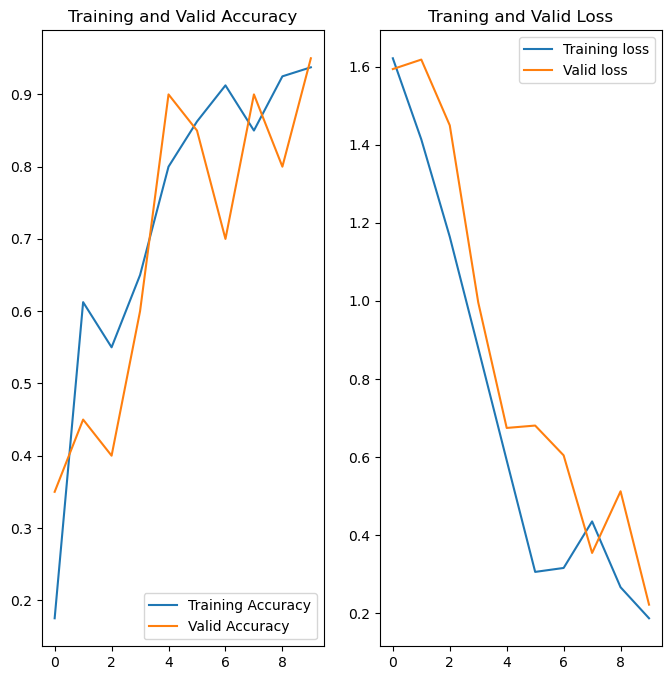

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label = 'Training Accuracy')
plt.plot(range(epochs),val_acc,label = 'Valid Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label = 'Training loss')
plt.plot(range(epochs),val_loss,label = 'Valid loss')
plt.legend(loc='upper right')
plt.title('Traning and Valid Loss')
plt.show()

## Creating a function for inference

In [57]:
def predict (model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    return pred_class,confidence

## Prediction on few Sample Images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


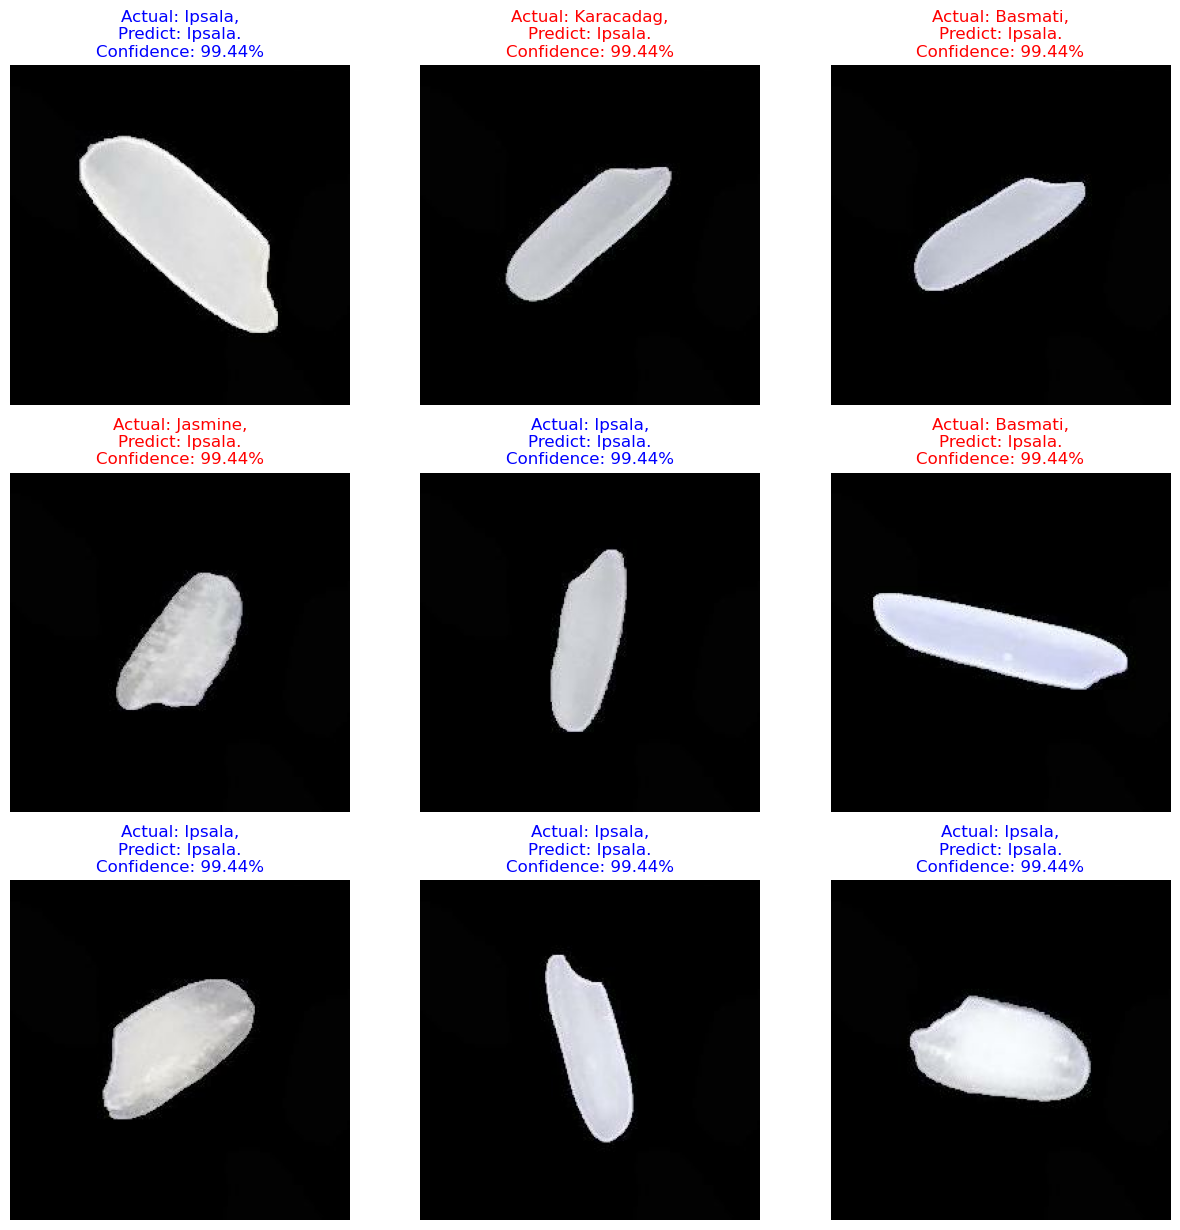

In [60]:
plt.figure(figsize=(15,15))
for i,(image,label) in enumerate(test_data.take(1)):
    for idx in range(9):
        ax = plt.subplot(3,3,idx+1)
        plt.imshow(image[idx].numpy().astype('uint8'))
        
        pred_class,confidence = predict(model,image[idx].numpy())
        actual_class = class_names[labels[idx]]

        ax.set_title(f'Actual: {actual_class},\nPredict: {pred_class}.\nConfidence: {confidence}%',color='blue' if pred_class == actual_class else 'red')
        ax.axis('off')

## Summary 
#### Model Prediction: 
The image shows an instance where the actual rice grain class is "Ipsala," and the model correctly predicts it with 99.44% confidence. Another example shows a misclassification where the actual class is "Karacadag," but the model predicts "Ipsala" with 99.44% confidence.